# Machine Learning with Python
---
---
The Process:
1. [Import dependencies and configure settings](#Step-1:-Import-dependencies-and-configure-settings)
2. [Load pre-processed data](#Step-2:-Load-pre-processed-data)
3. [Create LDA model instance](#Step-3:-Create-LDA-model-instance)
4. [Visualize the model results](#Step-4:-Visualize-the-model-results)

---

## Introduction to Topic Modeling
**Topic Model**
:  A type of statistical model for discovering the abstract "topics" that occur in a collection of documents, frequently used text-mining tool for discovery of hidden semantic structures in a text body

![topic-modeling](../images/topic_model_intro.png "Topic Modeling Intro")

---

## Step 1: Import dependencies and configure settings
### Import packages, modules, objects, or functions into the current notebook

***TIP: Avoid 'from PACKAGE import \*' syntax as it clutters your namespace with objects you may not be aware of***

In [1]:
# BEST PRACTICE: import built-in packages first
# from PACKAGE import OBJECT lets us bring only what we need into our namespace
from pprint import pprint
from warnings import filterwarnings

# BEST PRACTICE: import third-party packages second
# from PACKAGE import OBJECT as ALIAS, renames the object in our namespace
from gensim.models.ldamodel import LdaModel as gensim_LdaModel
from joblib import load as joblib_load
from pyLDAvis import enable_notebook as pyLDAvis_enable_notebook
from pyLDAvis.gensim_models import prepare as pyLDAvis_prepare_gensim
from seaborn import lineplot as seaborn_lineplot
# aliases can also be used when importing an individual module from the package
import matplotlib.pyplot as plt
# aliases can be added when fully importing packages
import pandas as pd

# BEST PRACTICE: import custom packages last
# for example: import custom_module as cm

### Configure settings by using functions or methods (always check the documentation)
Third-party packages used in this notebook:
- [Gensim](https://radimrehurek.com/gensim/)
- [Matplotlib](https://matplotlib.org/)
- [Pandas](https://pandas.pydata.org/pandas-docs/version/1.2.4/user_guide/index.html)
- [pyLDAvis](https://github.com/bmabey/pyLDAvis)
- [Seaborn](https://seaborn.pydata.org/)

In [2]:
# set python shell filter out warnings and avoid cluttering outputs
filterwarnings(
    'ignore'
)

In [3]:
# set custom pandas package options by iterating through key-value pairs in a dictionary
for option, value in { # dictionaries are denoted by curly brackets {} or the dict() function
    'display.max_columns': 50,
    'display.max_colwidth': None,
    'display.max_info_columns': 50,
    'display.max_rows': 20,
    'display.precision': 4
}.items(): # the .items() function of a dictionary lets us iterate through key, value pairs
    # we can call a function on the variable we set for the objects we're iterating over
    # in this case those variables are 'option', and 'value' and they represent
    # the key, value pairs from the dictionary above
    pd.set_option(
        option, # this will be 'display.max_columns' etc..
        value   # this will be 50, None, etc..
    )

In [4]:
# set pyLDAvis to render plots within IPython notebook cells
pyLDAvis_enable_notebook()

[Top](#Machine-Learning-with-Python)

---

## Step 2: Load pre-processed data
### Use [pickling](https://realpython.com/python-pickle-module/) to store python objects and reuse them across notebooks 
NOTE: Pickled files can only be 'unpickled' in an environment that matches the same dependencies as the one it was 'pickled' in, i.e. a colleague wouldn't be able to open pickled files if they don't have the same python environment on their machine  

> **WARNING: one should NEVER unpickle files from an unknown source as they may contain malicious software**

### Topic Model Requirements

**id2word**
: A python dictionary mapping the numerical identifiers created during pre-processing to the actual words they represent

**corpus**
: A 'bag of words' representation of each review in the dataset, converting text to a python list of tuples *--immutable objects--* in the form of (Word Identifier, Word Frequency)

NOTE: We use the Gensim package's functions to transform the text for us in the [Data Wrangling Notebook](./data_wrangling.ipynb)

In [5]:
# import corpus and id2words objects by 'unpickling' them
corpus = joblib_load(
    '../data/cocoon_reviews_corpus.pkl'
)
id2word = joblib_load(
    '../data/cocoon_reviews_id2word.pkl'
)

### Text Pre-processing Procedure

**1. Tokenization**: Split raw text into small, indivisible units for processing.
These can be:
- words
- n-grams
- sentences
- paragraphs

> n-gram
: A sequence of *n* number of words, i.e. a 2-gram, called a bigram, is a sequence of two words (“please turn”, “turn your”, or ”your homework”), and a 3-gram, called a trigram, is a three-word sequence of words (“please turn your”, or “turn your homework”)

**2. Normalization**: Convert all text to lower case, expand contractions, remove numerals and accent marks

> Contraction
: A word made by shortening and combining two words, i.e. can't (can + not), don't (do + not), and I've (I + have)

**3. Stopwords Removal**: Remove words below a certain length threshold or which contribute little overall meaning

> Stopwords
: Sets of commonly used words in given language, whose removal will increase overall meaning garnered from the text as only important or relevant words will remain

**4. Stemming or Lemmatization**: Eliminate affixes from a word by removing common word endings ('-ing', '-ed'), or tag each word by the part of speech it represent and then capturing canonical forms based on a word's lemma (chosen representative)

![stemming_vs_lemmatization](../images/stemming_vs_lemmatization.png)

> Stemming
: Cut off the end or the beginning of the word based on an algorithm, typically taking into account a list of common prefixes and suffixes that can be found in an inflected word in a given language

> Lemmatization
: Grouping words based on a morphological analysis of it's structure and definition. To do so it is necessary to have detailed dictionaries of words and their representatives, which the algorithms can look through to link the form back to a lemma.

> Parth-of-Speech Tagging
: A popular Natural Language Processing process which refers to categorizing words in a text (corpus) in correspondence with a particular part of speech, depending on the definition of the word and its context

### Why is part of speech tagging important to do before stemming or lemmatization?
![pos_example1](../images/pos_example1.png)
![pos_example2](../images/pos_example2.png)

[Top](#Machine-Learning-with-Python)

---

## Step 3: Create LDA model instance

**Latent Dirichlet Allocation (LDA)**  

A ‘generative probabilistic model’, seeking to allow sets of observations to be described by unobserved groups that explain why some parts of the data are similar. 

For example, if observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word’s presence is attributable to one of the document’s topics. In this case the documents are the reviews and the parts are the words and/or phrases (n-grams), with LDA serving as way of soft clustering the documents and parts. 

The fuzzy memberships drawn provide a more nuanced way of inferring topics, as each review can be made up of a combination of topics, versus simply attributing each review to one topic. This feature of LDA is key in this instance, as we are seeking to draw out terms indicative of constructive comments, with the assumption that customers might write about more than one topic in their reviews.

### *Optional*
[Tuning the hyperparameters](https://towardsdatascience.com/parameters-and-hyperparameters-aa609601a9ac), which are parameters whose values control the learning process and determine the values of model parameters that a learning algorithm ends up learning, is out of scope for this tutorial but a critical part of any successful model

For this Latent Dirichlet Allocation Model those would be:
- num_topics
- random_state
- update_every
- chunksize
- passes
- alpha
- per_word_topics

In [6]:
optimal_model = gensim_LdaModel(
    corpus = corpus,
    id2word = id2word,
    num_topics = 4,
    random_state = 100,
    update_every = 1,
    chunksize = 100,
    passes = 10,
    alpha = 'auto',
    per_word_topics = True
)
model_topics = optimal_model.show_topics(
    formatted = False
)

[Top](#Machine-Learning-with-Python)

---

## Step 4: Visualize the model results

In [7]:
pprint(optimal_model.print_topics())

[(0,
  '0.136*"use" + 0.118*"skin" + 0.046*"cream" + 0.044*"dry_skin" + '
  '0.041*"love" + 0.034*"help" + 0.033*"smell" + 0.025*"really" + 0.023*"year" '
  '+ 0.020*"day"'),
 (1,
  '0.054*"excellent" + 0.043*"cream" + 0.040*"body" + 0.038*"dry" + '
  '0.038*"time" + 0.029*"oil" + 0.025*"greasy" + 0.024*"hand" + 0.023*"skin" + '
  '0.022*"face"'),
 (2,
  '0.374*"good" + 0.093*"like" + 0.055*"one" + 0.048*"work" + 0.045*"balm" + '
  '0.043*"little" + 0.039*"quality" + 0.030*"price" + 0.024*"son" + '
  '0.016*"always"'),
 (3,
  '0.221*"product" + 0.078*"great" + 0.063*"recommend" + 0.053*"buy" + '
  '0.053*"nice" + 0.051*"available" + 0.030*"happy" + 0.028*"perfect" + '
  '0.021*"eczema" + 0.021*"soothe"')]


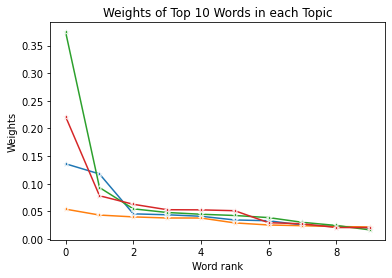

In [8]:
top_n_words = 10
topics = optimal_model.show_topics(
    num_topics =4, num_words = top_n_words, formatted = False)

for _, infos in topics:
    probs = [prob for _, prob in infos]
    seaborn_lineplot(range(top_n_words), probs, marker = '*')

plt.xlabel('Word rank')
plt.ylabel('Weights')
plt.title('Weights of Top {} Words in each Topic'.format(top_n_words))
plt.show()

In [9]:
LDAvis_prepared = pyLDAvis_prepare_gensim(optimal_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=            x       y  topics  cluster     Freq
topic                                          
0      0.2478 -0.0489       1        1  35.8306
1      0.2167  0.0269       2        1  29.3049
3     -0.2504 -0.3034       3        1  20.7576
2     -0.2142  0.3254       4        1  14.1069, topic_info=             Term      Freq     Total Category  logprob  loglift
32           good  383.0000  383.0000  Default  30.0000  30.0000
18        product  334.0000  334.0000  Default  29.0000  29.0000
13            use  355.0000  355.0000  Default  28.0000  28.0000
19           skin  354.0000  354.0000  Default  27.0000  27.0000
6            like   96.0000   96.0000  Default  26.0000  26.0000
..            ...       ...       ...      ...      ...      ...
149         moist    0.2184    4.6268   Topic4  -8.4533  -1.0948
117  moisturizing    0.2207    4.8423   Topic4  -8.4430  -1.1299
235      aquaphor    0.3357   13.3116   Topic4  -8.0236  -1.7218
166         crack    0.3146   18.1041   Topic4  -8.0884  -2.0942
224        easily    0.2905   18.5723   Topic4  -8.1680  -2.1993

[164 rows x 6 columns], token_table=      Topic    Freq             Term
term                                
168       2  0.9724           absorb
162       1  0.9875             also
58        4  0.9723           always
22        2  0.9886            amaze
51        1  0.9855            apply
...     ...     ...              ...
20        2  0.9615           winter
21        3  0.9395        wonderful
142       4  0.9829             work
30        2  0.9844  would_recommend
31        1  0.9966             year

[142 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

[Top](#Machine-Learning-with-Python)

---